In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
import keras.layers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization
from keras.regularizers import L1L2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import tensorflow as tf

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(0)
train, valid, test = pickle.load(open('dataset.pickle', 'rb'))
train = train.fillna(0)
valid = train.fillna(0)
test = test.fillna(0)

In [3]:
x_train = train[['raw_acc','proc_gyro','raw_magnet','watch_acceleration','watch_heading', 'location', 'location_quick_features', 'audio_naive', 'audio_properties', 'discrete', 'lf_measurements']]
y_train = train.iloc[:,-8:]
x_valid = valid[['raw_acc','proc_gyro','raw_magnet','watch_acceleration','watch_heading', 'location', 'location_quick_features', 'audio_naive', 'audio_properties', 'discrete', 'lf_measurements']]
y_valid = np.asarray(valid.iloc[:,-8:])
x_test = test[['raw_acc','proc_gyro','raw_magnet','watch_acceleration','watch_heading', 'location', 'location_quick_features', 'audio_naive', 'audio_properties', 'discrete', 'lf_measurements']]
y_test = np.asarray(test.iloc[:,-8:])

In [4]:
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
#x_train = np.asarray(x_train).reshape(x_train.shape[0], 1, x_train.shape[1])
x_valid = scaler.fit_transform(x_valid)
x_test = scaler.fit_transform(x_test)
#x_test = np.asarray(x_test).reshape(x_test.shape[0], 1, x_test.shape[1])

In [5]:
model = Sequential()
#model.add(LSTM(500, input_shape=(x_train.shape[1], x_train.shape[2]), bias_regularizer=L1L2(l1=0.01, l2=0.01)))
#model.add(LSTM(500, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(2000, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
history = model.fit([x_train], batch_size=100, y=y_train, verbose=1, validation_data=(x_valid, y_valid), 
          shuffle=True, epochs=20)

Train on 297773 samples, validate on 297773 samples
Epoch 1/20
297773/297773 [==============================] - 55s 186us/step - loss: 1.0518 - acc: 0.6165 - val_loss: 0.9971 - val_acc: 0.6240
Epoch 2/20
297773/297773 [==============================] - 58s 195us/step - loss: 0.9685 - acc: 0.6433 - val_loss: 0.9152 - val_acc: 0.6632
Epoch 3/20
297773/297773 [==============================] - 62s 208us/step - loss: 0.9274 - acc: 0.6583 - val_loss: 0.8597 - val_acc: 0.6838
Epoch 4/20
297773/297773 [==============================] - 62s 208us/step - loss: 0.8980 - acc: 0.6716 - val_loss: 0.8308 - val_acc: 0.6959
Epoch 5/20
297773/297773 [==============================] - 62s 209us/step - loss: 0.8767 - acc: 0.6799 - val_loss: 0.8294 - val_acc: 0.6928
Epoch 6/20
297773/297773 [==============================] - 63s 211us/step - loss: 0.8639 - acc: 0.6850 - val_loss: 0.8184 - val_acc: 0.7046
Epoch 7/20
297773/297773 [==============================] - 63s 212us/step - loss: 0.8475 - acc: 0.691

In [7]:
predicted = model.predict(x_test)
predicted = np.argmax(predicted, axis=1)
y_test_decode = np.argmax(y_test, axis=1)
print(accuracy_score(y_test_decode, predicted))

0.4927398920348133


Train: 0.746, Valid: 0.746, Test: 0.493


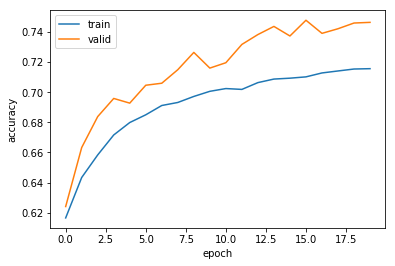

In [9]:
# evaluate the model
_, acc_train = model.evaluate(x_train, y_train, verbose=0)
_, acc_valid = model.evaluate(x_valid, y_valid, verbose=0)
_, acc_test = model.evaluate(x_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f, Test: %.3f' % (acc_train, acc_valid, acc_test))
# learning curves of model accuracy
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='valid')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [11]:
# save model
import os
dir_name = 'nn'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
filename = dir_name + '/2layers_val_20epoch.nn'
model.save(filename)
print('Saved %s' % filename)

Saved nn/2layers_val_20epoch.nn
